In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_mixed_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [3]:
gibson_data = pd.read_csv("../data/gibson_wu_2013.csv")
gibson_data.head()

,subj,item,type,pos,word,correct,rt,region,type2,so
0,1,13,obj-ext,8,男人,-,1561,headnoun,object relative,1
1,1,6,subj-ext,8,女孩,-,959,headnoun,subject relative,-1
2,1,5,obj-ext,8,轎車,-,582,headnoun,object relative,1
3,1,9,obj-ext,8,探員,-,294,headnoun,object relative,1
4,1,14,subj-ext,8,空服員,-,438,headnoun,subject relative,-1


In [4]:
gibson_data.tail()

,subj,item,type,pos,word,correct,rt,region,type2,so
542,9,15,obj-ext,8,演員,-,406,headnoun,object relative,1
543,9,16,subj-ext,8,記者,-,342,headnoun,subject relative,-1
544,9,7,obj-ext,8,狗,-,478,headnoun,object relative,1
545,9,8,subj-ext,8,業餘選手,-,510,headnoun,subject relative,-1
546,9,11,obj-ext,8,球員,-,350,headnoun,object relative,1


In [5]:
gibson_data.shape

(547, 10)

In [6]:
gibson_data["RT"] = gibson_data["rt"] / 1000

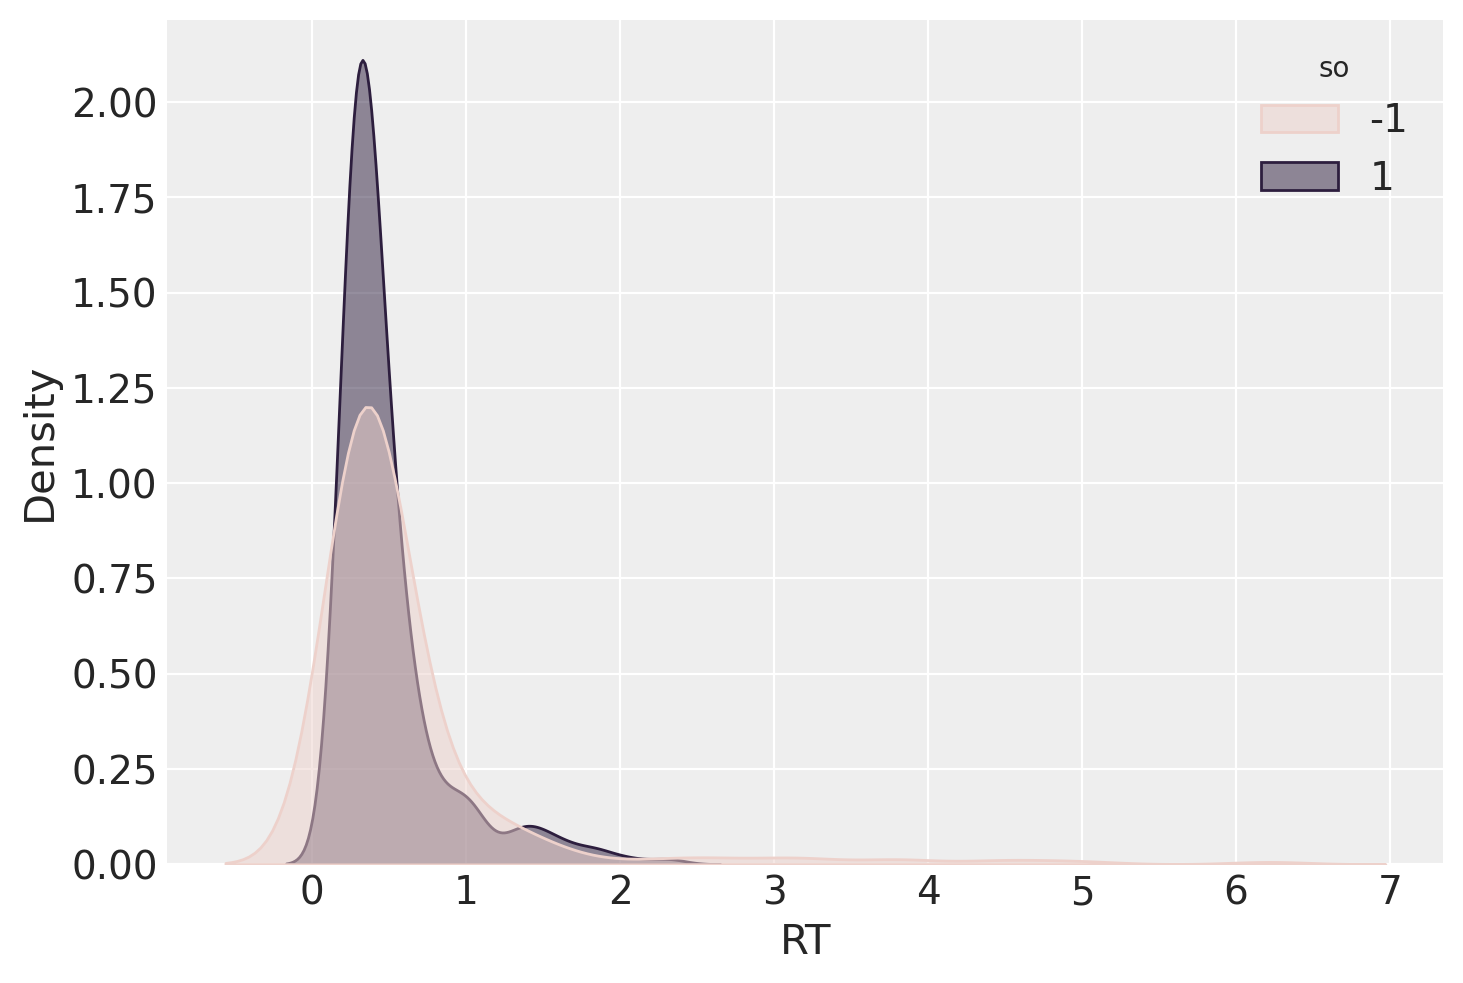

In [7]:
_ = sns.kdeplot(data=gibson_data, x='RT', hue='so', fill=True, common_norm=False, alpha=0.5)

In [8]:
stan_file = os.path.join("stan", "fixed_effects.stan")
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=1> N;                // Number of data points
  vector[N] rt;                  // Reading time
  vector[N] so;                  // Predictor, constrained between -1 and 1
}
parameters {
  vector[2] beta;                // Intercept and slope
  real<lower=0> sigma_e;         // Error standard deviation
}
model {
  vector[N] mu;

  // Define the model for mu using vectorized operations
  mu = beta[1] + beta[2] * so;

  // Vectorized likelihood
  rt ~ lognormal(mu, sigma_e);
}



In [9]:
stan_data = {
    "N" : gibson_data.shape[0],
    "rt" : gibson_data["RT"],
    "so" : gibson_data["so"] 
}

In [10]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=fixed_effects
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/fixed_effects.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/fixed_effects
	 compiler_options=stanc_options={}, cpp_options={}


In [11]:
fit = model.sample(data=stan_data)

09:49:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:40 - cmdstanpy - INFO - CmdStan done processing.


09:49:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.st

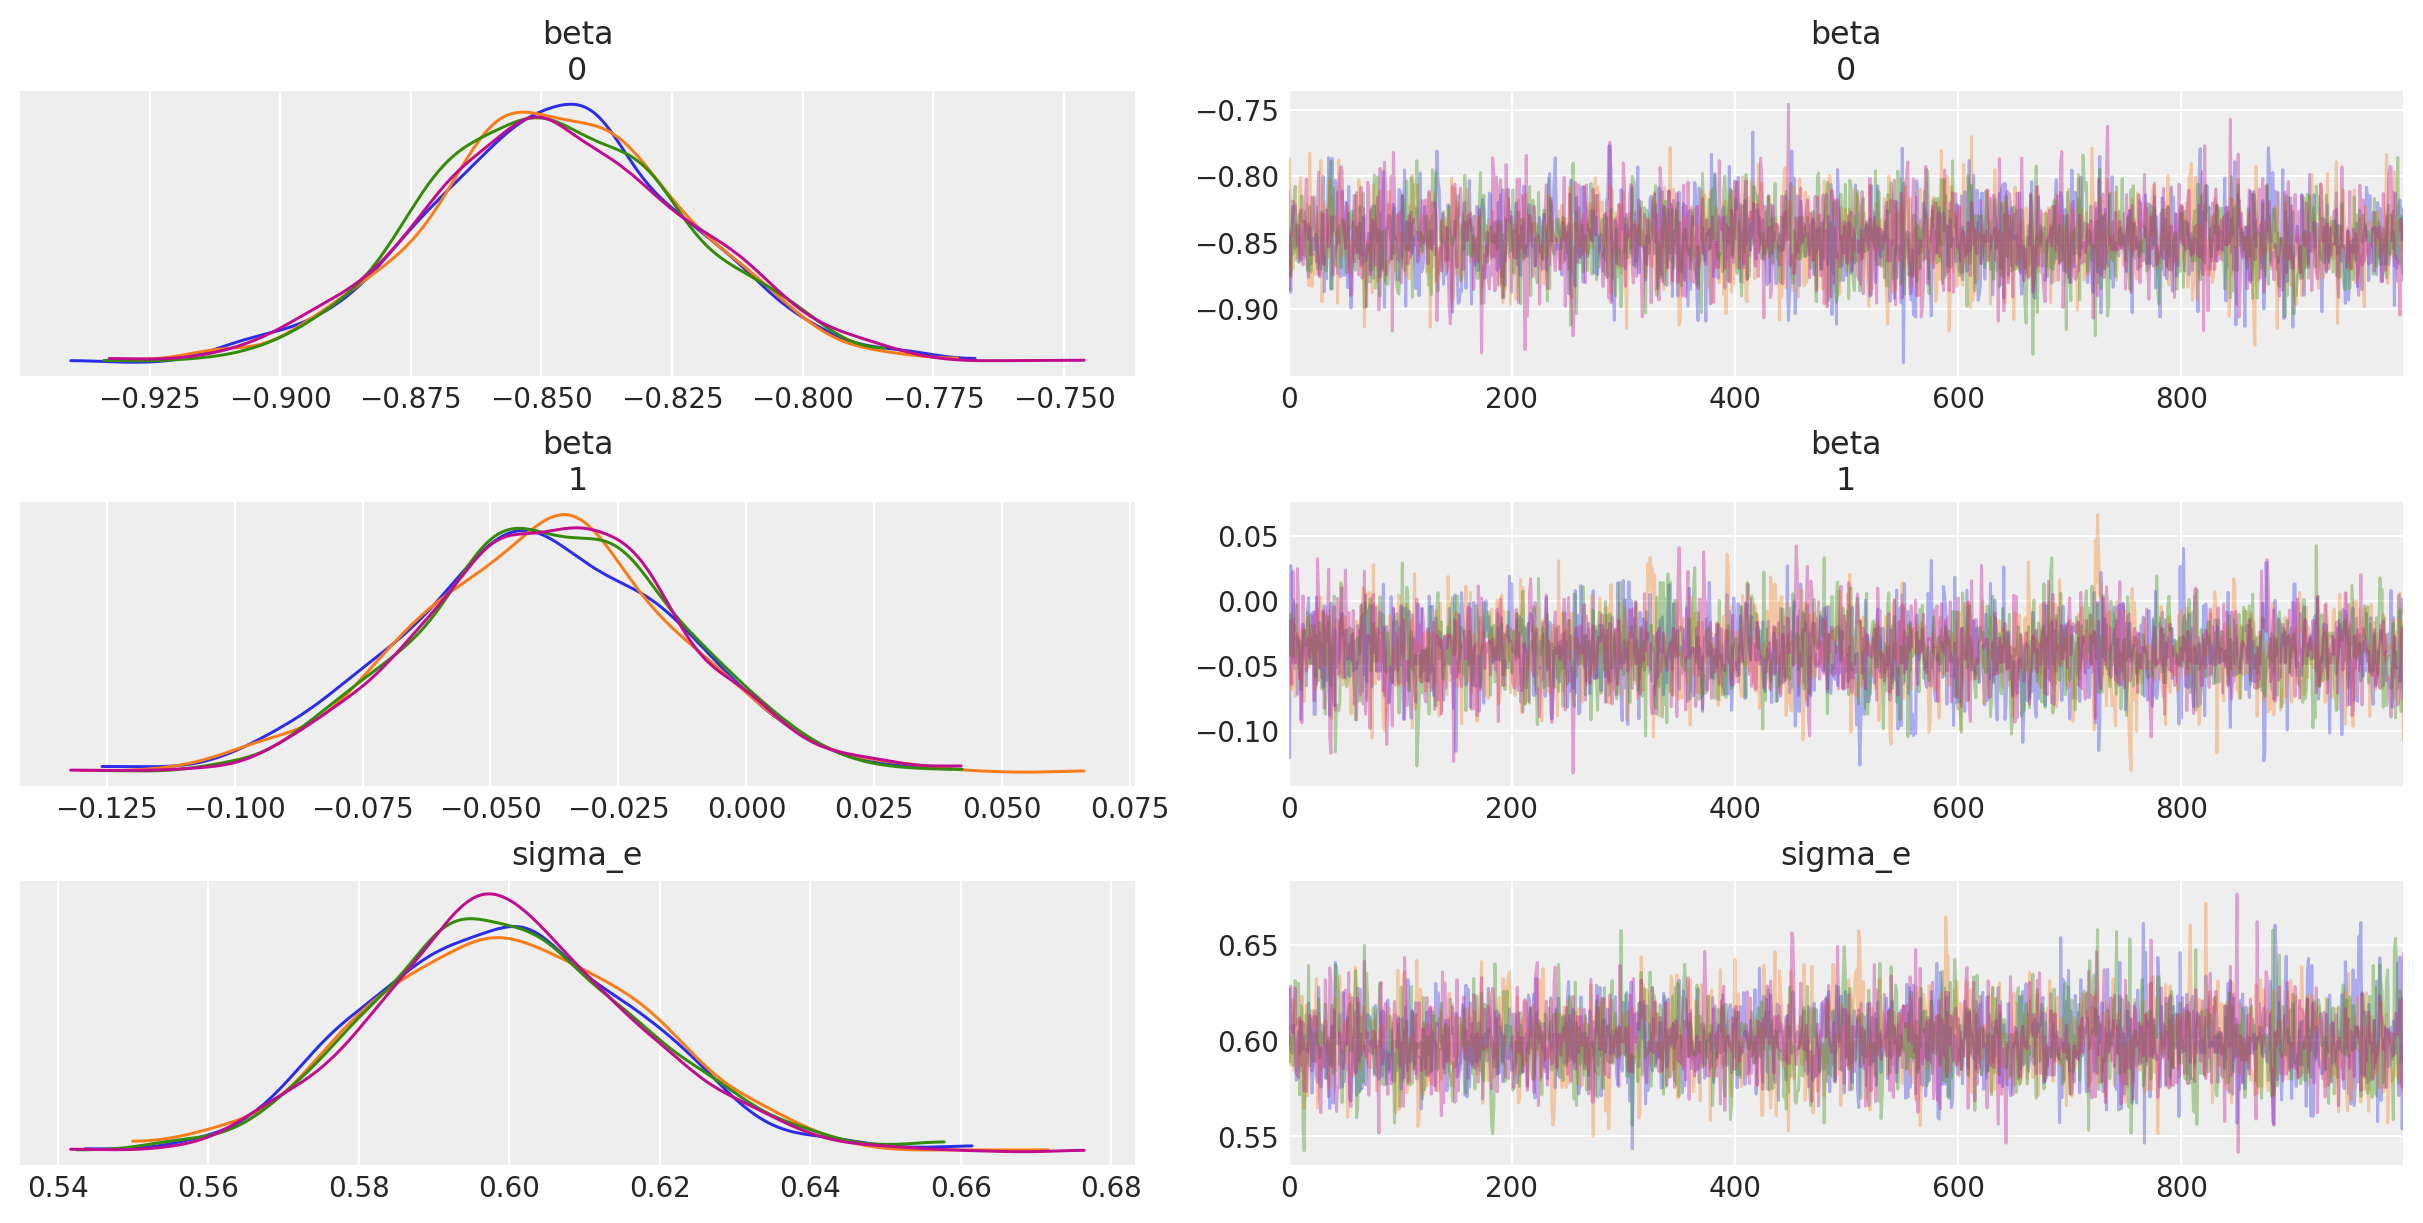

In [12]:
_ = az.plot_trace(fit, var_names=(["beta", "sigma_e"]), compact=False)

In [13]:
az.summary(fit, var_names=(["beta", "sigma_e"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.85,0.03,-0.90,-0.80,0.0,0.0,4355.34,3020.79,1.0
beta[1],-0.04,0.03,-0.09,0.01,0.0,0.0,3479.05,2620.73,1.0
sigma_e,0.60,0.02,0.56,0.63,0.0,0.0,4142.93,2915.28,1.0


In [14]:
stan_file = os.path.join('stan', 'random_intercepts.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;                  // Number of data points
  vector[N] rt;                    // Reading time
  vector[N] so;                    // Predictor, constrained between -1 and 1
  int<lower=0> J;                  // Number of subjects
  int<lower=0> K;                  // Number of items
  array[N] int<lower=0, upper=J> subj;
  array[N] int<lower=0, upper=K> item;
}
parameters {
  vector[2] beta;                  // Fixed intercept and slope
  vector[J] u;                     // Subject intercepts
  vector[K] w;                     // Item intercepts
  real<lower=0> sigma_e;           // Error standard deviation
  real<lower=0> sigma_u;           // Subject standard deviation
  real<lower=0> sigma_w;           // Item standard deviation
}
model {
  vector[N] mu;

  // Priors
  beta ~ normal(0, 5);             // Assuming a weakly informative prior for beta
  u ~ normal(0, sigma_u);
  w ~ normal(0, sigma_w);
  sigma_e ~ exponential(1);
  sigma_u ~ exponential(1);
  sig

In [15]:
stan_data = {
    'subj': pd.factorize(gibson_data['subj'])[0] + 1,
    'item': pd.factorize(gibson_data['item'])[0] + 1,
    'rt': gibson_data['RT'].values,
    'so': gibson_data['so'].values,
    'N': len(gibson_data),
    'J': gibson_data['subj'].nunique(),
    'K': gibson_data['item'].nunique()
}

In [16]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=random_intercepts
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/random_intercepts.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/random_intercepts
	 compiler_options=stanc_options={}, cpp_options={}


In [17]:
fit = model.sample(data=stan_data)

09:49:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:42 - cmdstanpy - INFO - CmdStan done processing.


09:49:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'random_intercepts.stan', line 23, column 2 to column 25)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_intercepts.stan', line 31, column 2 to column 30)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'random_intercepts.stan', line 23, column 2 to column 25)
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_intercepts.stan', line 31, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_intercepts.stan', line 31, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_intercepts.stan', line 31, column 2 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'random_intercepts.stan', line

In [18]:
az.summary(fit, var_names=(["beta", "sigma_e", "sigma_u", "sigma_w"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.85,0.07,-0.98,-0.70,0.0,0.0,972.81,1432.20,1.0
beta[1],-0.04,0.02,-0.08,0.01,0.0,0.0,9907.41,2792.55,1.0
sigma_e,0.52,0.02,0.49,0.55,0.0,0.0,6892.29,2924.56,1.0
sigma_u,0.25,0.04,0.18,0.33,0.0,0.0,3483.27,3242.25,1.0
sigma_w,0.20,0.05,0.11,0.30,0.0,0.0,3282.73,3064.55,1.0


In [19]:
stan_file = os.path.join('stan', 'random_slopes.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;                  // Number of data points
  vector[N] rt;                    // Reading time
  vector[N] so;                    // Predictor, constrained between -1 and 1
  int<lower=0> J;                  // Number of subjects
  int<lower=0> K;                  // Number of items
  array[N] int<lower=0, upper=J> subj;
  array[N] int<lower=0, upper=K> item;
}
parameters {
  vector[2] beta;                  // Fixed intercept and slope
  real<lower=0> sigma_e;           // Error standard deviation
  matrix[2,J] u;                   // Subject intercepts and slopes
  vector<lower=0>[2] sigma_u;      // Subject standard deviations
  matrix[2,K] w;                   // Item intercepts and slopes
  vector<lower=0>[2] sigma_w;      // Item standard deviations
}
model {
  // Priors
  for (j in 1:J) {
    u[1,j] ~ normal(0, sigma_u[1]); // Prior for subject intercepts
    u[2,j] ~ normal(0, sigma_u[2]); // Prior for subject slopes
  }
  
  for (k in 1:K) {
    w[1,k] ~

In [20]:
model = CmdStanModel(stan_file=stan_file)

In [21]:
fit = model.sample(
    data=stan_data,
    iter_sampling = 2000,
    iter_warmup = 1000,
)

09:49:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:52 - cmdstanpy - INFO - CmdStan done processing.


09:49:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'random_slopes.stan', line 26, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 3

09:49:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.1%)
	Chain 2 had 5 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [22]:
az.summary(fit, var_names=(["beta", "sigma_e", "sigma_u", "sigma_w"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.85,0.07,-1.00,-0.72,0.0,0.0,1461.17,1751.00,1.00
beta[1],-0.04,0.03,-0.09,0.02,0.0,0.0,5508.88,5552.50,1.00
sigma_e,0.52,0.02,0.48,0.55,0.0,0.0,6844.66,5534.36,1.00
sigma_u[0],0.25,0.04,0.18,0.34,0.0,0.0,4641.74,4106.93,1.00
sigma_u[1],0.06,0.03,0.01,0.12,0.0,0.0,149.23,151.91,1.04
sigma_w[0],0.20,0.05,0.11,0.30,0.0,0.0,4248.61,3128.32,1.00
sigma_w[1],0.04,0.03,0.00,0.09,0.0,0.0,257.94,234.94,1.01


In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanp

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanp: not installed

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.13.1
numpy     : 1.26.4
seaborn   : 0.13.2
arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.8.4

Watermark: 2.4.3

